# **Computer Vision - Detecção e Reconhecimento Facial**

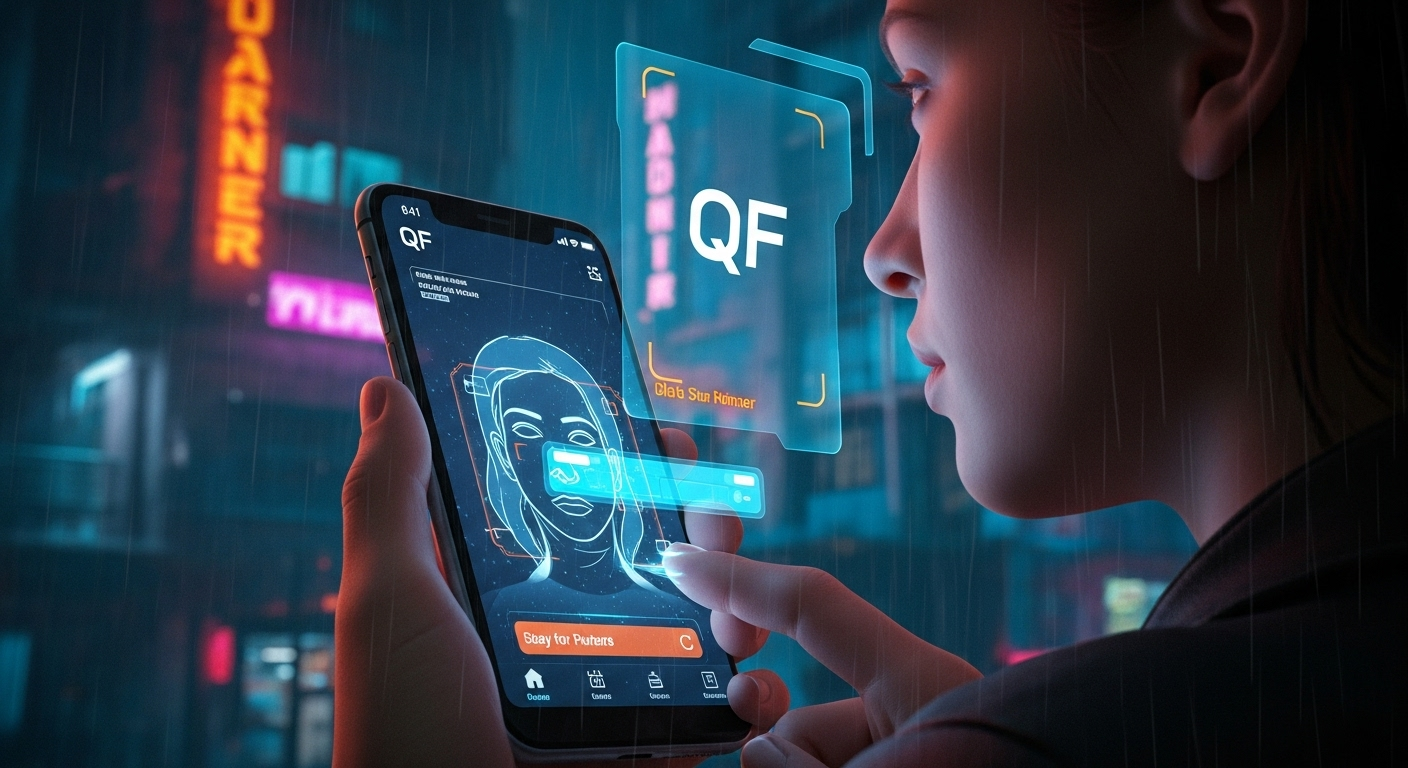

# **Introdução**  
# **Equipe**
# José Basílio   RM 357240
# Lucas Santos   RM 358024
# Rafael Gallo   RM 358285
# Társis Tavares RM 358921

## **Contextualização**

## A **Quantum Finance** é uma Fintech que está entrando no mercado para concorrer com grandes players. Seus steakholders desejam  começar o novo negócio de forma assertiva, com um direcionamento alinhado a estratégia de dados e inteligência artificial.   

### **Proposta de valor:** Oferecer soluções financeiras singulares e automatizadas utilizando AI.  
### **Visão:** Um mundo onde a experiência financeira descomplicada, personalizada e segura viabilize os sonhos de todos.  
### **Missão:** Empoderar a todos com soluções financeiras inclusivas, inovadoras e personalizadas para suas necessidades e interesses, por meio de uma plataforma inteligente, confiável e democrática.  
### **Propósito:** Transformamos seu futuro em presente!  

## **Fato gerador:** O setor de fraudes apontou que existem clientes que se queixaram de não contratar serviços específicos, como o crédito pessoal.  
## No entanto, os protocolos de segurança da senha foram realizados em conformidade, cada cliente autenticou com sua própria senha.  
## Em função disso, o banco precisa arcar com reembolsos e medidas de contenção para evitar processos judiciais, pois os clientes alegam terem sido invadidos por hackers ou algo similar.  

# **Objetivo**  

## Será necessário construir:  

### **Detector de faces.**  
### **Identificação de faces.**  
### **Detecção de vivacidade (liveness) para evitar que um fraudador utilize uma foto estática.**   

# Contextualização histórica
•	1960s: Criado o primeiro sistema semi-automatizado ("Man-Machine System"), que media distâncias entre pontos faciais (olhos, nariz, boca). Requeria intervenção humana para alinhar fotos e tinha precisão limitada. Usado em projetos de segurança governamental durante a Guerra Fria.  
•	1973: A Universidade de Kyoto desenvolveu o primeiro sistema totalmente automatizado. Seu algoritmo detectava rostos frontais, mas falhava com ângulos ou iluminação variáveis. Hardware da época não permitia processamento em tempo real.  
•	1991: Turk e Pentland (MIT) Introduziram Eigenfaces, usando Análise de Componentes Principais (PCA) para comprimir informações faciais em "assinaturas" matemáticas. Reduziu custo computacional e permitiu reconhecimento em bancos de dados grandes.  
•	2001: Paul Viola e Michael J Jones (Microsoft Research) Criaram o Haar Cascades, um detector de rostos em tempo real usando características simples (ex: região dos olhos mais escura que as bochechas).
Inovação: 100x mais rápido que métodos anteriores. Padrão no OpenCV até hoje.  
•	2014: DeepFace (Facebook AI Research) Alcançou mais de 97% de precisão (equivalente a humanos) usando Redes Neurais Convolucionais (CNNs).
Feito: Treinado com 4 milhões de rostos de usuários do Facebook (polêmico por questões de privacidade).  
•	2015: FaceNet (Google) Funcionava mesmo com poucas imagens de treinamento.  
•	2017: Apple Face ID Combinou sensor infravermelho, mapeamento 3D e redes neurais on-device. Taxa de falsos positivos: 1 em 1.000.000.  
________________________________________  
Aplicações em Segurança e Pagamentos  
•	2018: Caixas automáticas do BBVA (Espanha) com reconhecimento facial.  
•	2019: Mastercard Identity Check: "Selfie Pay" para confirmar transações via app.  
•	Alipay (China): "Smile to Pay" (2017), usado em redes de fast-food.  
•	iD da Apple: Integra Face ID a Apple Pay para autorizar compras.  
•	Brasil: Gov.br usa reconhecimento facial para acesso a serviços públicos (2021).  
•	Amazon Go: Lojas sem checkout (2020), onde câmeras identificam clientes e itens comprados.  
________________________________________  
Desafios Atuais  
•	Deepfakes: Vídeos falsos burlam autenticação (ex.: golpe de US$ 35 milhões em banco dos Emirados, 2020).  
•	Regulação: Leis como GDPR (UE) e LGPD (Brasil) exigem consentimento explícito.  


# Bibliotecas

In [ ]:
!pip install mediapipe==0.10.9 deepface opencv-python-headless --quiet
import mediapipe as mp
from deepface import DeepFace
import os
import numpy as np
import cv2
import time
import sys
import os
from IPython.display import display, Javascript, clear_output, HTML
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import matplotlib.pyplot as plt
import dlib
from scipy.spatial import distance as dist



## Inicialização

In [ ]:
# Inicializar MediaPipe
mp_face_detection = mp.solutions.face_detection

# Exibição na mesma tela do Jupyter
%matplotlib inline

# Baixar o arquivo de landmarks faciais
if not os.path.exists("shape_predictor_68_face_landmarks.dat"):
    print("Baixando arquivo de landmarks faciais...")
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bunzip2 shape_predictor_68_face_landmarks.dat.bz2

# Inicializar detector de pontos faciais do dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")



### Camera - Rotina em Javascrip para adaptação ao Google Colab

In [ ]:
def setup_camera():
    """Função para acessar a webcam com limpeza do display"""
    clear_output()
    js_code = """
    // Remove qualquer container de câmera existente
    var existingContainer = document.getElementById('camera-container');
    if (existingContainer) {
        existingContainer.remove();
    }

    // Cria novo container
    var div = document.createElement('div');
    div.id = 'camera-container';
    document.body.appendChild(div);

    div.innerHTML = `
        <video id="webcam" autoplay playsinline style="display: none;"></video>
        <canvas id="canvas" style="display: none;"></canvas>
        <img id="output" style="display: block; margin: auto; border: 1px solid #ddd;">
    `;

    async function setupCamera() {
        const video = document.getElementById('webcam');
        try {
            const stream = await navigator.mediaDevices.getUserMedia({
                'video': { width: 640, height: 480, facingMode: 'user' },
                'audio': false,
            });
            video.srcObject = stream;
            return new Promise((resolve) => {
                video.onloadedmetadata = () => {
                    resolve();
                };
            });
        } catch (err) {
            console.error("Erro ao acessar a câmera: ", err);
            throw err;
        }
    }

    async function captureFrame() {
        try {
            const video = document.getElementById('webcam');
            const canvas = document.getElementById('canvas');
            const context = canvas.getContext('2d');

            if (!video.videoWidth || !video.videoHeight) {
                return null;
            }

            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            return canvas.toDataURL('image/jpeg');
        } catch (err) {
            console.error("Erro ao capturar frame: ", err);
            return null;
        }
    }

    setupCamera().catch(err => {
        console.error("Falha na inicialização da câmera: ", err);
    });
    """
    display(Javascript(js_code))
    time.sleep(4)

# Identificação de figura humana - _Liveness_

## Limpeza de execução anterior

In [ ]:
def clean_previous_execution():
    """Limpa qualquer execução anterior"""
    clear_output()
    eval_js("""
    var container = document.getElementById('camera-container');
    if (container) {
        container.remove();
    }
    """)
    time.sleep(1)

## _Webcam_

## Captura de frame

In [ ]:
def capture_frame():
    """Função para capturar um frame da webcam"""
    try:
        js_result = eval_js('captureFrame()')
        if not js_result:
            return None
        binary = b64decode(js_result.split(',')[1])
        return binary
    except Exception as e:
        print(f"Erro ao capturar frame: {e}")
        return None

## Atualização do display

In [ ]:
def update_display(frame):
    """Atualiza o display com o frame processado"""
    try:
        _, buffer = cv2.imencode('.jpg', frame)
        frame_b64 = b64encode(buffer).decode('utf-8')
        update_img_js = (
            "var outputElement = document.getElementById('output');"
            "if (outputElement) {"
            f"  outputElement.src = 'data:image/jpeg;base64,{frame_b64}';"
            "}"
        )
        eval_js(update_img_js)
    except Exception as e:
        print(f"Erro ao atualizar display: {e}")

## Detecção de piscar através de EAR - Eye Aspect Ratio

### Cálculo do EAR

In [ ]:
def eye_aspect_ratio(eye_points):
    """Calcula a proporção de abertura dos olhos (EAR)"""
    # Calcula as distâncias euclidianas verticais
    A = dist.euclidean(eye_points[1], eye_points[5])
    B = dist.euclidean(eye_points[2], eye_points[4])

    # Calcula a distância euclidiana horizontal
    C = dist.euclidean(eye_points[0], eye_points[3])

    # Calcula a proporção
    ear = (A + B) / (2.0 * C)
    return ear

def detect_blinks(frame):
    """Detecta piscadas usando pontos faciais"""
    try:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray, 0)

        if len(faces) == 0:
            return frame, 0

        face = faces[0]
        shape = predictor(gray, face)
        shape = np.array([(shape.part(i).x, shape.part(i).y) for i in range(68)])

        # Índices dos pontos dos olhos
        left_eye_indices = [36, 37, 38, 39, 40, 41]
        right_eye_indices = [42, 43, 44, 45, 46, 47]

        left_eye = shape[left_eye_indices]
        right_eye = shape[right_eye_indices]

        # Calcula a proporção de abertura dos olhos
        left_ear = eye_aspect_ratio(left_eye)
        right_ear = eye_aspect_ratio(right_eye)

        # Média das duas proporções
        ear = (left_ear + right_ear) / 2.0

        # Desenha contornos dos olhos
        left_eye_hull = cv2.convexHull(left_eye)
        right_eye_hull = cv2.convexHull(right_eye)
        cv2.drawContours(frame, [left_eye_hull], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [right_eye_hull], -1, (0, 255, 0), 1)

        return frame, ear

    except Exception as e:
        print(f"Erro na detecção de piscadas: {e}")
        return frame, 0

## Detecção de piscar de olhos

In [ ]:
def liv_detec():
    """Função aprimorada para detecção de liveness usando piscar de olhos"""
    print("Detectando liveness...")
    clean_previous_execution()
    setup_camera()

    # Constantes para detecção de piscadas
    EYE_AR_THRESH = 0.25  # Limiar para considerar olho fechado
    EYE_AR_CONSEC_FRAMES = 2  # Número de frames consecutivos para considerar piscada
    COUNTER = 0
    TOTAL = 0
    max_time = 30  # segundos

    start_time = time.time()
    ear_history = []

    display(HTML('<span style="font-size:22px; font-weight:bold; color:blue;">🤗 Por favor, pisque 2 vezes para verificação ...</span>'))

    while time.time() - start_time < max_time:
        frame_binary = capture_frame()
        if frame_binary is None:
            time.sleep(0.1)
            continue

        frame = cv2.imdecode(np.frombuffer(frame_binary, dtype=np.uint8), cv2.IMREAD_COLOR)
        if frame is None or frame.size == 0:
            time.sleep(0.1)
            continue

        # Detecta piscadas
        processed_frame, ear = detect_blinks(frame.copy())
        ear_history.append(ear)

        # Verifica se o olho está fechado
        if ear < EYE_AR_THRESH:
            COUNTER += 1
        else:
            # Se os olhos estavam fechados por tempo suficiente, conta como piscada
            if COUNTER >= EYE_AR_CONSEC_FRAMES:
                TOTAL += 1
                print(f"Piscada detectada! Total: {TOTAL}/2")

            COUNTER = 0

        # Mostra informações no frame
        cv2.putText(processed_frame, f"Piscadas: {TOTAL}/2", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(processed_frame, f"EAR: {ear:.2f}", (10, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(processed_frame, f"Tempo: {int(max_time - (time.time() - start_time))}s", (10, 90),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        update_display(processed_frame)

        if TOTAL >= 2:
            display(HTML('<span style="font-size:22px; font-weight:bold; color:green;">✅ Figura humana confirmada</span>'))
            return True

        time.sleep(0.1)

    display(HTML('<span style="font-size:22px; font-weight:bold; color:red;">❌ Identificação inválida! Não detectada figura humana</span>'))
    print(f"Histórico EAR: {np.mean(ear_history):.2f} (média)")
    return False

## Detecção de faces

In [ ]:
def detect_faces(frame):
    """Função para detectar faces com Viola-Jones"""
    if frame is None or frame.size == 0:
        return None, False

    try:
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        if face_cascade.empty():
            print("Erro: Classificador não carregado!")
            return frame, False

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        face_detected = len(faces) > 0

        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

        return frame, face_detected
    except Exception as e:
        print(f"Erro na detecção facial: {e}")
        return frame, False

# _Loop_ para detecção de faces

In [ ]:
def face_detection_loop():
    """Loop principal de detecção facial"""
    # Limpeza completa antes de começar
    clean_previous_execution()

    # Configura a câmera
    setup_camera()

    # Mensagem inicial
    display(HTML('<span style="font-size:22px; font-weight:bold; color:blue;">👍 Pressione qualquer tecla para iniciar o reconhecimento facial...</span>'))
    input()

    start_time = time.time()
    timeout = 10
    face_detected = False

    print("Iniciando detecção facial por 10 segundos...")

    while time.time() - start_time < timeout:
        frame_binary = capture_frame()
        if frame_binary is None:
            time.sleep(0.1)
            continue

        frame = cv2.imdecode(np.frombuffer(frame_binary, dtype=np.uint8), cv2.IMREAD_COLOR)
        if frame is None or frame.size == 0:
            time.sleep(0.1)
            continue

        processed_frame, found_face = detect_faces(frame)

        if processed_frame is not None and processed_frame.size > 0:
            update_display(processed_frame)

        if found_face:
            imagem = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            plt.imshow(imagem)
            plt.axis('off')
            cv2.imwrite('face.jpg', frame)
            print("\n✅ Rosto detectado! Imagem salva como 'face.jpg'")
            face_detected = True
            break

        time.sleep(0.1)

    if not face_detected:
        print("\n❌ Nenhum rosto detectado durante os 10 segundos.")

    # Limpeza final
    eval_js("""
    var container = document.getElementById('camera-container');
    if (container) {
        container.remove();
    }
    """)
    print("\nPrograma encerrado.")

# Autorização de acesso

In [ ]:
def acc_allow():
  # Inicializar MediaPipe
  mp_face_detection = mp.solutions.face_detection

  # Função para detectar e recortar rosto
  def detect_and_crop_face(image_path):
      image = cv2.imread(image_path)
      if image is None:
          return None
      image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
          results = face_detection.process(image_rgb)
          if results.detections:
              for detection in results.detections:
                  bbox = detection.location_data.relative_bounding_box
                  h, w, _ = image.shape
                  x, y, w_box, h_box = int(bbox.xmin * w), int(bbox.ymin * h), int(bbox.width * w), int(bbox.height * h)
                  cropped_face = image[y:y+h_box, x:x+w_box]
                  return cropped_face
      return None

  # Recortar rosto da imagem principal
  face_image = detect_and_crop_face('face.jpg')
  if face_image is None:
      print("❌ Nenhum rosto detectado em 'face.jpg'.")
  else:
      cv2.imwrite('cropped_face.jpg', face_image)

      best_match = None
      best_similarity = 0
      matched = False

      # Threshold mais permissivo para o modelo Facenet
      custom_threshold = 0.83 # Ajustar identificação da pessoa <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
      for filename in os.listdir('id_faces'):
          if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
              image_path = os.path.join('id_faces', filename)
              cropped = detect_and_crop_face(image_path)

              if cropped is not None:
                  print("Analisando arquivo: ",filename)
                  temp_path = f"temp_{filename}"
                  cv2.imwrite(temp_path, cropped)

                  try:
                      result = DeepFace.verify(
                          img1_path='cropped_face.jpg',
                          img2_path=temp_path,
                          model_name='Facenet',
                          enforce_detection=False
                      )
                      distance = result['distance']
                      similarity = 1 - distance

                      if distance < custom_threshold:
                          person_name = os.path.splitext(filename)[0]
                          display(HTML('<span style="font-size:40px; font-weight:bold; color:green;">🎉 Acesso LIBERADO ✅</span>'))
                          print(f"\n🎉 Identificação positiva para {person_name}, Similaridade: {similarity:.2f}")
                          matched = True
                          break
                      else:
                          if similarity > best_similarity:
                              best_similarity = similarity
                              mel_sim = filename
                  except Exception as e:
                      print(f"Erro ao comparar com {filename}: {e}")
                  finally:
                      os.remove(temp_path)
              else:
                  # print(f"⚠️ Nenhum rosto detectado em {filename}, imagem ignorada.")
                  print()
                  print()
                  print()
                  print()
                  display(HTML('<span style="font-size:22px; font-weight:bold; color:green;">⚠️ Nenhum rosto detectado. Imagem ignorada</span>'))
                  print(f"\n⚠️Rosto não detectado em {filename}")


      if not matched:
                  print()
                  print()
                  print()
                  print()
                  display(HTML('<span style="font-size:40px; font-weight:bold; color:green;">🚫 Identificação NEGATIVA. Acesso BLOQUEADO ❌</span>'))
                  print(f"\n🚫 Melhor similaridade: {best_similarity:.2f} = {mel_sim}")

# Fluxo principal

### Detecção de _Liveness_

In [ ]:
# Fluxo principal
print("Sistema de Verificação Biométrica")
flag = liv_detec() # Deteção de liveness

### Deteção de face

In [ ]:

if flag:
    face_detection_loop() # Deteção de rosto
else:
    # Limpeza final se liveness falhar
    eval_js("""
    var container = document.getElementById('camera-container');
    if (container) {
        container.remove();
    }
    """)
    print("❌ Sistema encerrado devido a falha na verificação de liveness.")
    sys.exit(1)

### Autorização de acesso

In [ ]:
acc_allow() # Autorização de acesso